In [71]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

(757, 567, 3)


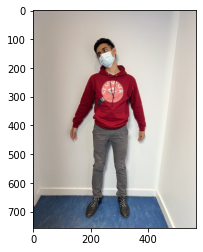

In [72]:
image = plt.imread('paras-background.jpg')
print(image.shape)
plt.imshow(image)

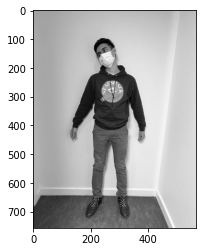

In [73]:
gray = rgb2gray(image)
plt.imshow(gray, cmap='gray')

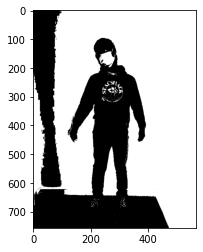

In [74]:

gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

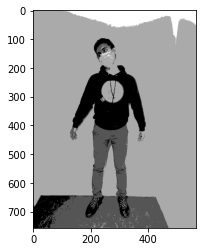

In [75]:
gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

(757, 567)


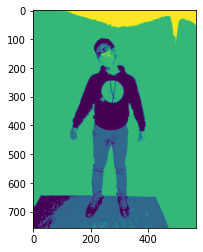

In [76]:
if len(gray.shape) > 2 and gray.shape[2] == 4:
    #convert the image from RGBA2RGB
    gray = cv2.cvtColor(gray, cv2.COLOR_BGRA2BGR)
print(gray.shape)
plt.imshow(gray)

In [77]:
# converting to grayscale
# gray = rgb2gray(image)

# defining the sobel filters
sobel_horizontal = np.array([2*np.array([1, 2, 1]), np.array([0, 0, 0]), 2*np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')
 
sobel_vertical = np.array([2*np.array([-1, 0, 1]), 2*np.array([-2, 0, 2]), 2*np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 2  4  2]
 [ 0  0  0]
 [-2 -4 -2]] is a kernel for detecting horizontal edges
[[-2  0  2]
 [-4  0  4]
 [-2  0  2]] is a kernel for detecting vertical edges


In [78]:
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')
# here mode determines how the input array is extended when the filter overlaps a border.


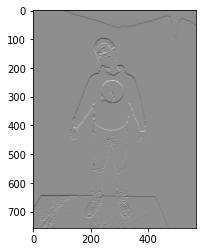

In [79]:
plt.imshow(out_h, cmap='gray')

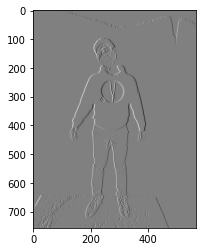

In [80]:
plt.imshow(out_v, cmap='gray')

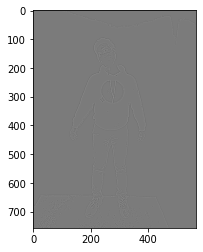

In [81]:
kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])
out_l = ndimage.convolve(gray, kernel_laplace)
plt.imshow(out_l, cmap='gray')

(757, 567, 3)


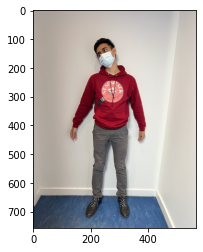

In [86]:
pic = plt.imread('paras-background.jpg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)

In [87]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(429219, 3)

In [88]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

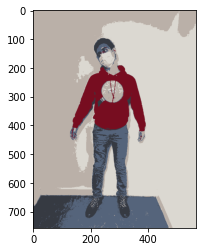

In [89]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)